## Environment setup

In [85]:
#I think that the version of mlxtend installed in Colab is not compatible with the version of scikit-learn.
#I downgrade the version of sklearn from 1.6.1 to 1.4.2
!pip install scikit-learn==1.4.2 mlxtend==0.23.1 xgboost==2.0.3 lightgbm==4.3.0

In [86]:
!pip install catboost

## Loading Packages

In [87]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
# visualizing library
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error

from xgboost.sklearn import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor

from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [88]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Dataset/calorie

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dataset/calorie


## Importing Dataset

In [89]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv',index_col=0)
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [90]:
test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5


In [91]:
print(f'train shape: {train.shape}, test shape: {test.shape}')

train shape: (750000, 8), test shape: (250000, 7)


## EDA

### Missing Value

In [92]:
train.isnull().sum()

,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0
Calories,0


In [93]:
test.isnull().sum()

,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0


### Outlier

In [94]:
def findOutliers(dataset,column):
  """
  findOutliers: Return the list of outliers in a specific column of the dataset using the IQR method.

  Parameter
  ----------------------------
  dataset: dataframe
  column: str, the name of column

  Returns
  ____________________________
  int, the list of outliers in a specific column of the dataset
  """
  q1 = dataset[column].quantile(0.25)
  q3 = dataset[column].quantile(0.75)
  iqr = q3 - q1

  y = dataset[(dataset[column] > (q3 + 1.5*iqr)) | (dataset[column] < (q1 - 1.5*iqr))]

  return y

def countOutliers(dataset, column):
  """
  countOutliers: Return how many outliers are in a specific column of the dataset using the IQR method.

  Parameter
  ----------------------------
  dataset: dataframe
  column: str, the name of column

  Returns
  ____________________________
  int, the number of outliers in a specific column of the dataset
  """
  return len(findOutliers(dataset, column))

In [95]:
X = train.drop('Sex',axis=1)

In [96]:
for column in X.columns:
  print(f"the number of IQR outliers in {column} of train set: {str(countOutliers(X, column))}")

the number of IQR outliers in Age of train set: 0
the number of IQR outliers in Height of train set: 14
the number of IQR outliers in Weight of train set: 9
the number of IQR outliers in Duration of train set: 0
the number of IQR outliers in Heart_Rate of train set: 36
the number of IQR outliers in Body_Temp of train set: 14919
the number of IQR outliers in Calories of train set: 139


In [97]:
figSize = plt.rcParams['figure.figsize']
figSize[0] = 10
figSize[1] = 10
plt.rcParams['figure.figsize'] = figSize

<ipython-input-98-9d0348612f12>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, patch_artist=True, labels=['Height','Weight','Heart_Rate','Body_Temp','Calories'])


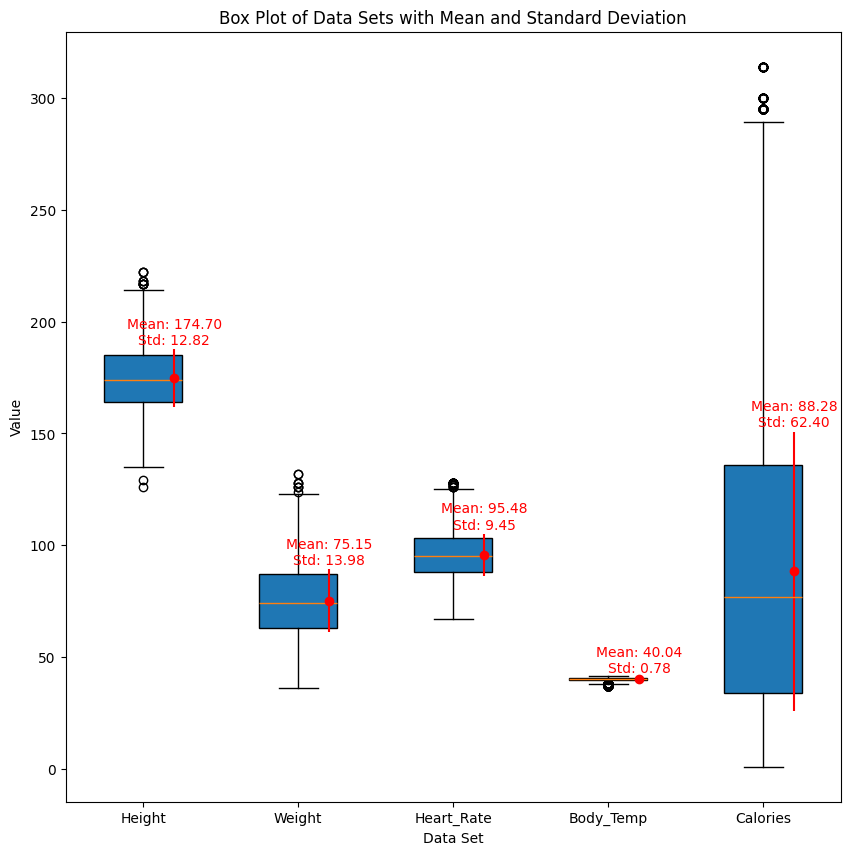

In [98]:
data = [train.Height, train.Weight, train.Heart_Rate, train.Body_Temp, train.Calories]

plt.boxplot(data, patch_artist=True, labels=['Height','Weight','Heart_Rate','Body_Temp','Calories'])

# Calculate the mean and stds
means = [np.mean(train.Height), np.mean(train.Weight), np.mean(train.Heart_Rate), np.mean(train.Body_Temp), np.mean(train.Calories)]
stds = [np.std(train.Height), np.std(train.Weight), np.std(train.Heart_Rate), np.std(train.Body_Temp), np.std(train.Calories)]

# indicate the means, stds, and errorbars
x = [1.2, 2.2, 3.2, 4.2, 5.2]  # 각 데이터 세트의 x 위치를 약간 옆으로 조정
plt.errorbar(x, means, yerr=stds, fmt='o', color='red', label='Mean ± Std Dev')

for i, (mean, std) in enumerate(zip(means, stds), start=1):
    plt.text(i + 0.2, mean + std + 1, f'Mean: {mean:.2f}\nStd: {std:.2f}',
             ha='center', va='bottom', color='red')

# set title and labels
plt.title('Box Plot of Data Sets with Mean and Standard Deviation')
plt.xlabel('Data Set')
plt.ylabel('Value')

plt.show()

In [99]:
outliers_in_Height = findOutliers(X,'Height')
outliers_in_Weight = findOutliers(X, 'Weight')
outliers_in_Heart_Rate = findOutliers(X, 'Heart_Rate')
outliers_in_Body_Temp = findOutliers(X, 'Body_Temp')
outliers_in_Calories = findOutliers(X, 'Calories')
print(f"outliers in Height:\n{outliers_in_Height.describe()}")

outliers in Height:
             Age      Height      Weight   Duration  Heart_Rate  Body_Temp  \
count  14.000000   14.000000   14.000000  14.000000   14.000000  14.000000   
mean   41.428571  205.500000  101.857143  20.642857  103.500000  40.528571   
std     8.697606   33.109957   32.554941   9.580486   11.921216   0.699922   
min    26.000000  126.000000   41.000000   5.000000   78.000000  39.100000   
25%    35.750000  217.000000   71.750000  11.250000   95.250000  40.350000   
50%    41.000000  217.000000  118.000000  26.500000  105.000000  40.800000   
75%    46.500000  218.000000  127.500000  27.750000  112.250000  40.975000   
max    60.000000  222.000000  132.000000  30.000000  120.000000  41.300000   

         Calories  
count   14.000000  
mean   150.357143  
std     85.587209  
min     20.000000  
25%     67.500000  
50%    191.000000  
75%    218.000000  
max    240.000000  


In [100]:
outliers_in_Height.corr().Height

,Height
Age,-0.056628
Height,1.000000
Weight,0.714714
Duration,0.139801
Heart_Rate,0.197710
Body_Temp,0.092609
Calories,0.218639


In [101]:
outliers_in_Weight.corr().Weight

,Weight
Age,-0.119293
Height,0.427593
Weight,1.000000
Duration,-0.287012
Heart_Rate,-0.141961
Body_Temp,0.027960
Calories,-0.291155


In [102]:
outliers_in_Heart_Rate.corr().Heart_Rate

,Heart_Rate
Age,0.091698
Height,0.328455
Weight,0.404827
Duration,0.232417
Heart_Rate,1.000000
Body_Temp,0.496416
Calories,0.365142


In [103]:
outliers_in_Body_Temp.corr().Body_Temp

,Body_Temp
Age,0.044705
Height,0.003110
Weight,0.005895
Duration,0.144549
Heart_Rate,0.009415
Body_Temp,1.000000
Calories,0.065517


In [104]:
outliers_in_Calories.corr().Calories

,Calories
Age,-0.032752
Height,0.296561
Weight,0.232257
Duration,-0.023108
Heart_Rate,-0.274154
Body_Temp,-0.092868
Calories,1.000000


In [105]:
print(f"Normal:\n{X.describe()}")

Normal:
                 Age         Height         Weight       Duration  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       41.420404     174.697685      75.145668      15.421015   
std        15.175049      12.824496      13.982704       8.354095   
min        20.000000     126.000000      36.000000       1.000000   
25%        28.000000     164.000000      63.000000       8.000000   
50%        40.000000     174.000000      74.000000      15.000000   
75%        52.000000     185.000000      87.000000      23.000000   
max        79.000000     222.000000     132.000000      30.000000   

          Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  
mean       95.483995      40.036253      88.282781  
std         9.449845       0.779875      62.395349  
min        67.000000      37.100000       1.000000  
25%        88.000000      39.600000      34.000000  
50%        95.000000      40.300000      77.000000  

In [106]:
print(f"outliers in Weight:\n{outliers_in_Weight.describe()}")

outliers in Weight:
             Age      Height      Weight   Duration  Heart_Rate  Body_Temp  \
count   9.000000    9.000000    9.000000   9.000000    9.000000   9.000000   
mean   44.555556  214.333333  127.777778  22.444444  102.333333  40.611111   
std    13.398798    6.500000    2.728451   9.435453   10.111874   0.691817   
min    21.000000  204.000000  124.000000   6.000000   81.000000  38.900000   
25%    38.000000  209.000000  126.000000  18.000000   99.000000  40.600000   
50%    45.000000  217.000000  128.000000  28.000000  105.000000  40.700000   
75%    47.000000  218.000000  128.000000  28.000000  109.000000  41.000000   
max    65.000000  222.000000  132.000000  30.000000  113.000000  41.300000   

         Calories  
count    9.000000  
mean   166.333333  
std     85.179223  
min     14.000000  
25%    105.000000  
50%    209.000000  
75%    218.000000  
max    246.000000  


In [107]:
print(f"outliers in Heart Rate:\n{outliers_in_Heart_Rate.describe()}")

outliers in Heart Rate:
             Age      Height      Weight   Duration  Heart_Rate  Body_Temp  \
count  36.000000   36.000000   36.000000  36.000000   36.000000  36.000000   
mean   51.805556  183.416667   87.305556  28.666667  127.666667  40.863889   
std    17.358110    9.649204   10.090503   2.000000    0.676123   0.192951   
min    20.000000  158.000000   59.000000  23.000000  126.000000  40.400000   
25%    37.000000  179.000000   82.000000  29.000000  128.000000  40.775000   
50%    54.500000  187.000000   90.000000  29.000000  128.000000  40.900000   
75%    65.000000  189.000000   93.000000  30.000000  128.000000  41.000000   
max    79.000000  195.000000  105.000000  30.000000  128.000000  41.300000   

         Calories  
count   36.000000  
mean   272.861111  
std     40.196768  
min    160.000000  
25%    289.000000  
50%    289.000000  
75%    289.000000  
max    295.000000  


In [108]:
print(f"outliers in Body_Temp:\n{outliers_in_Body_Temp.describe()}")

outliers in Body_Temp:
                Age        Height        Weight      Duration    Heart_Rate  \
count  14919.000000  14919.000000  14919.000000  14919.000000  14919.000000   
mean      38.485220    176.998928     77.223540      1.252698     80.964140   
std       14.879361     12.907552     14.044748      0.757822      4.806915   
min       20.000000    135.000000     45.000000      1.000000     67.000000   
25%       26.000000    168.000000     66.000000      1.000000     78.000000   
50%       33.000000    177.000000     77.000000      1.000000     81.000000   
75%       49.000000    188.000000     89.000000      1.000000     84.000000   
max       79.000000    211.000000    114.000000     29.000000    123.000000   

          Body_Temp     Calories  
count  14919.000000  14919.00000  
mean      37.724814      4.12092  
std        0.157115      5.45214  
min       37.100000      1.00000  
25%       37.700000      3.00000  
50%       37.700000      4.00000  
75%       37.900000 

In [109]:
print(f"outliers in Calories:\n{outliers_in_Calories.describe()}")

outliers in Calories:
              Age      Height      Weight    Duration  Heart_Rate   Body_Temp  \
count  139.000000  139.000000  139.000000  139.000000  139.000000  139.000000   
mean    66.280576  188.733813   92.640288   28.870504  120.661871   40.833094   
std     13.332443    7.844111    8.834228    1.062091    3.855269    0.352710   
min     29.000000  170.000000   75.000000   25.000000  108.000000   37.700000   
25%     64.000000  182.000000   88.000000   29.000000  119.000000   40.800000   
50%     72.000000  189.000000   93.000000   29.000000  120.000000   40.900000   
75%     75.000000  194.000000   98.000000   29.000000  123.000000   40.900000   
max     79.000000  213.000000  123.000000   30.000000  128.000000   41.300000   

         Calories  
count  139.000000  
mean   299.705036  
std      7.177313  
min    295.000000  
25%    295.000000  
50%    295.000000  
75%    300.000000  
max    314.000000  


In [110]:
index_outliers_in_Calories = outliers_in_Calories.index

In [111]:
Duration_30 = X[X.Duration==30.0]
Duration_30

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,
24,45,184.0,79.0,30.0,108.0,41.1,187.0
117,30,185.0,89.0,30.0,106.0,41.0,185.0
210,30,161.0,64.0,30.0,104.0,41.0,176.0
233,45,174.0,78.0,30.0,112.0,40.8,225.0
264,75,179.0,75.0,30.0,102.0,41.2,194.0
...,...,...,...,...,...,...,...
749700,63,184.0,76.0,30.0,112.0,40.6,215.0
749723,79,188.0,95.0,30.0,104.0,40.8,250.0
749865,41,162.0,60.0,30.0,104.0,40.8,184.0


In [112]:
index_duration_30 = X[X.Duration==30.0].index
index_duration_30

Index([    24,    117,    210,    233,    264,    299,    364,    374,    416,
          417,
       ...
       749420, 749514, 749552, 749586, 749610, 749700, 749723, 749865, 749874,
       749995],
      dtype='int64', name='id', length=12464)

### The distribution of Data

In [113]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv',index_col=0)

In [114]:
X = train.copy()

In [115]:
def transform(X, scale=False):
  index = ['Duration','Heart_Rate','Age_Heart_Rate','Body_Temp','Calories_per_minute','Temp_Effort','Intensity', 'BMR_Duration', 'Heart_Rate_/_Age','Temp_Effort_Duration']

  X['Sex'] = X.Sex.map({'male':0, 'female':1})
  X['log_Body_Temp'] = np.log1p(X['Body_Temp'])
  X['log_Age'] = np.log1p(X['Age'])
  X['Intensity'] = X['Heart_Rate'] * X['Duration']
  X['log_Intensity'] = np.log1p(X['Intensity'])
  X['Calories_per_minute'] = X['Duration'] / X['Heart_Rate']
  X['Weight_Duration'] = X['Weight'] * X['Duration']
  X['Temp_Effort'] = X['Body_Temp']/X['Heart_Rate']
  X['Duration_Heart_Weight'] = X['Duration'] * X['Heart_Rate'] * X['Weight']
  X['Age_Heart_Rate'] = X['Age'] * X['Heart_Rate']
  X['BMR'] = X.apply(lambda x: (10*x['Weight'] + 6.25*x['Height'] - 5*x['Age'] + 5) if x['Sex'] == 0 else (10*x['Weight'] + 6.25*x['Height'] - 5*x['Age'] - 161), axis=1)
  X['BMR_Duration'] = X['BMR']*X['Duration']
  X['Age_Body_Temp'] = X['Age'] * X['Body_Temp']
  X['Duration^2'] = X['Duration']*X['Duration']
  X['Body_Temp^2'] = X['Body_Temp']*X['Body_Temp']
  X['Heart_Rate^2'] = X['Heart_Rate']*X['Heart_Rate']
  X['Age^2'] = X['Age']*X['Age']
  X['Heart_Rate_/_Age'] = X['Heart_Rate']/X['Age']
  X['Temp_Effort_Duration'] = X['Temp_Effort']*X['Duration']
  X = X.iloc[:][index]
  if scale:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
  return X


In [116]:
#X = X[train.Duration < 30]
y = X.Calories
X = X.drop('Calories', axis=1)

In [117]:
X = transform(X, False)
X, val_X,y, val_y = train_test_split(X,y, test_size=.2, random_state=50, shuffle=True )

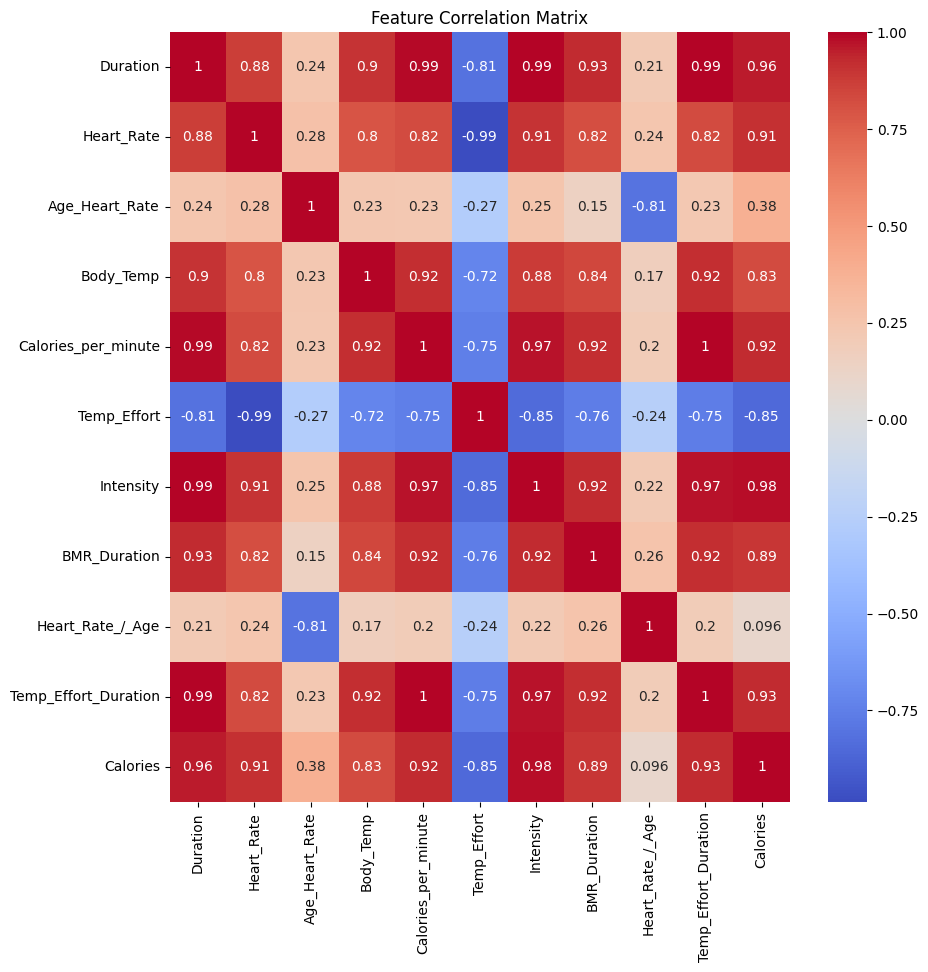

In [118]:
z = transform(train)
z['Calories'] = y
#plt.figure(figsize=(10, 6))
sns.heatmap(z.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [119]:
model_list = [RFR(random_state=50),
              GBR(random_state=50),
              XGBR(random_state=50),
              LGBR(random_state=50),
              DTR(random_state=50),
              KNN(),
              MLP(random_state=50),
              CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=5, random_state=42, verbose=0)
              ]

accuracy = []

y_log = np.log1p(y)
for model in model_list:
  print(f"{str(model)}:done")
  regressor = model.fit(X,y_log)
  y_pred = regressor.predict(val_X)
  y_pred = np.expm1(y_pred)
  print(f"The number of negative results: {len(y_pred[y_pred < 0])}")
  acc = root_mean_squared_log_error(abs(y_pred),val_y)
  accuracy.append(acc)
  print(acc)

print(accuracy)

RandomForestRegressor(random_state=50):done
The number of negative results: 0
0.06753923445348674
GradientBoostingRegressor(random_state=50):done
The number of negative results: 0
0.08535496747556488
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=50, ...):done
The number of negative results: 0
0.06799190448180

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The number of negative results: 0
0.10904194553369248
<catboost.core.CatBoostRegressor object at 0x7a51a0b71350>:done
The number of negative results: 0
0.08393083330637206
[np.float64(0.06753923445348674), np.float64(0.08535496747556488), np.float64(0.06799190448180317), np.float64(0.07044880709221482), np.float64(0.09133073427031946), np.float64(0.09603251752995), np.float64(0.10904194553369248), np.float64(0.08393083330637206)]


In [120]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

xgb = XGBR(random_state=50)
lgb = LGBR(random_state=50, force_col_wise = True)
gbr = GBR(random_state=50)
rfr= RFR(random_state=50)
mlp= MLP(random_state=50)
cat=CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=5, random_state=42, verbose=0)

# 스태킹
stack = StackingCVRegressor(
    regressors=(xgb, lgb, cat),
    meta_regressor=XGBR(random_state=40),#Ridge(alpha=1.0),
    cv=5,
    use_features_in_secondary=True
)

#grid = GridSearchCV(

#)
#y_log = np.log1p(y)
# 학습 및 예측
stack_regressor = stack.fit(X, y_log)
y_pred = stack_regressor.predict(val_X)

#y_pred_log = np.log1p(y_pred)
y_pred = np.expm1(y_pred)
#validation_y_orig = np.expm1(validation_y)
rmsle = root_mean_squared_log_error(val_y, np.clip(y_pred, a_min=0, a_max=None))
print(f"스태킹 RMSLE: {rmsle}")

[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141889
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141466
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 10
[LightGBM] [Info] Start training from score 4.140009
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 10
[LightGBM] [Info] Start training from score 4.140030
[LightGBM] [Info] Total Bins 1921
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141701
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 600

In [121]:
#model1 = MLP(random_state=50)
model2 = XGBR(random_state=50)
model3 = LGBR(random_state=50)
model4 = CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=5, random_state=50, verbose=0, loss_function="RMSE")
y_log = np.log1p(y)
#regressor1 = model1.fit(X,y_log)
regressor2 = model2.fit(X,y_log)
regressor3 = model3.fit(X,y_log)
regressor4 = model4.fit(X,y_log)

for regressor in [regressor2, regressor3, regressor4]:
  pred = regressor.predict(val_X)
  pred = np.expm1(pred)
  acc = root_mean_squared_log_error(np.clip(pred, a_min=0, a_max=None),val_y)
  print(f"blended predictions acc:{acc}")

def blended_predictions(X):
    return (#(0.1 * regressor1.predict(X)) + \
            (0.2 * regressor2.predict(X)) + \
            (0.2 * regressor3.predict(X)) + \
            (0.2 * regressor4.predict(X)) + \
            (0.4 * stack.predict(X)))

pred = blended_predictions(val_X)
pred = np.expm1(pred)
print(f"The number of negative results: {len(pred[pred < 0])}")
acc = root_mean_squared_log_error(np.clip(pred, a_min=0, a_max=None),val_y)
print(f"blended predictions acc:{acc}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141019
blended predictions acc:0.06799190448180317
blended predictions acc:0.07044880709221482
blended predictions acc:0.08345107966932147
The number of negative results: 0
blended predictions acc:0.06776831912818256


In [124]:
import shap

explainer1 = shap.Explainer(regressor2)
explainer2 = shap.Explainer(regressor3)
explainer3 = shap.Explainer(regressor4)
#explainer4 = shap.Explainer(stack)

shap_values1 = explainer1(val_X)
shap_values2 = explainer2(val_X)
shap_values3 = explainer3(val_X)
#shap_values4 = explainer4(val_X)

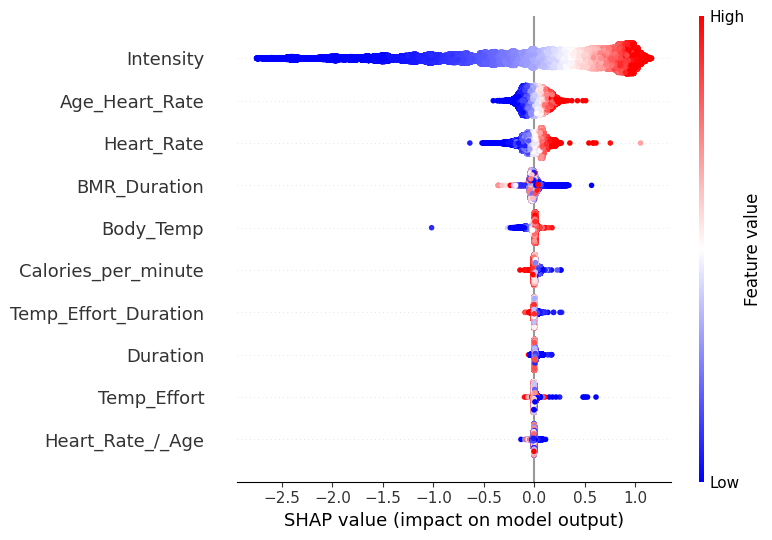

In [125]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values1, val_X,
                  cmap='bwr',
                  show=False,
                 )

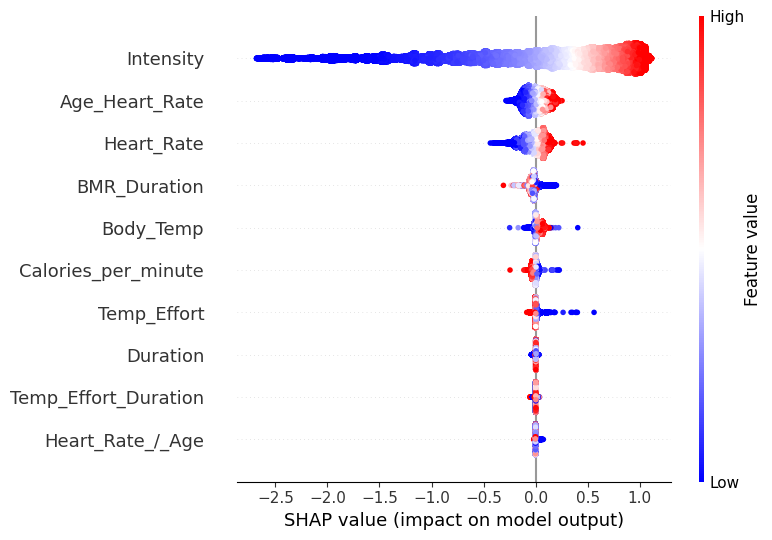

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values2, val_X,
                  cmap='bwr',
                  show=False,
                 )

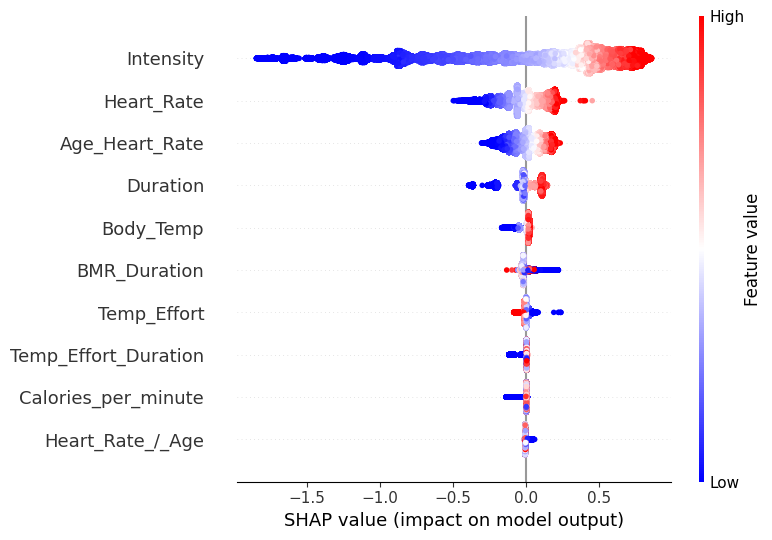

In [126]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values3, val_X,
                  cmap='bwr',
                  show=False,
                 )

In [132]:
test = pd.read_csv('test.csv',index_col=0)

In [133]:
test = transform(test, False)
test

,Duration,Heart_Rate,Age_Heart_Rate,Body_Temp,Calories_per_minute,Temp_Effort,Intensity,BMR_Duration,Heart_Rate_/_Age,Temp_Effort_Duration
id,,,,,,,,,,
750000,7.0,87.0,3915.0,39.8,0.080460,0.457471,609.0,11873.75,1.933333,3.202299
750001,20.0,101.0,2626.0,40.5,0.198020,0.400990,2020.0,41900.00,3.884615,8.019802
750002,16.0,102.0,2958.0,40.4,0.156863,0.396078,1632.0,27504.00,3.517241,6.337255
750003,20.0,107.0,4173.0,40.6,0.186916,0.379439,2140.0,28980.00,2.743590,7.588785
750004,16.0,94.0,2820.0,40.5,0.170213,0.430851,1504.0,23044.00,3.133333,6.893617
...,...,...,...,...,...,...,...,...,...,...
999995,6.0,85.0,4760.0,39.4,0.070588,0.463529,510.0,7036.50,1.517857,2.781176
999996,3.0,84.0,2688.0,38.4,0.035714,0.457143,252.0,6352.50,2.625000,1.371429
999997,14.0,98.0,3038.0,40.1,0.142857,0.409184,1372.0,18886.00,3.161290,5.728571


In [134]:
pred = blended_predictions(test)
pred = np.expm1(pred)
print(pred[pred<0])

[]


In [135]:
result = pd.DataFrame({'id':test.index, 'Calories':abs(pred)})
result

,id,Calories
0,750000,28.497145
1,750001,107.714658
2,750002,85.078625
3,750003,125.593581
4,750004,73.560044
...,...,...
249995,999995,25.958357
249996,999996,9.243632
249997,999997,73.135917
249998,999998,172.799368


In [136]:
result.to_csv("predictions.csv", index=False)